In [1]:
# Dependencies
from src.dataset import GaussianNoise, SaltPepperNoise, OcclusionNoise, RandomNoise, Clip, ToTensor, Compose
from src.dataset import MNIST, train_test_split
from src.network import AutoEncoder, train_test_epochs
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import torch
import tqdm
import json
import os

# Get best device
device = torch.device('cuda') if torch.cuda.is_available() else torch.cpu()
# Show selected device
print('Selected device:', device)

# Setup matplotlib
%matplotlib inline

Selected device: cuda


In [2]:
# Define path to root folder
ROOT_PATH = '.'
# Define path to data folder
DATA_PATH = ROOT_PATH + '/data'
# Define path to MNIST dataset
MNIST_PATH = DATA_PATH +'/MNIST.mat'
# Define path to modles folder
MODEL_PATH = DATA_PATH + '/models'

In [3]:
# Load MNIST dataset from file
mnist = MNIST.from_mat(MNIST_PATH)

# Show mnist dataset length
print('Loaded MNIST dataset contains {:d} images'.format(len(mnist)))

Loaded MNIST dataset contains 60000 images


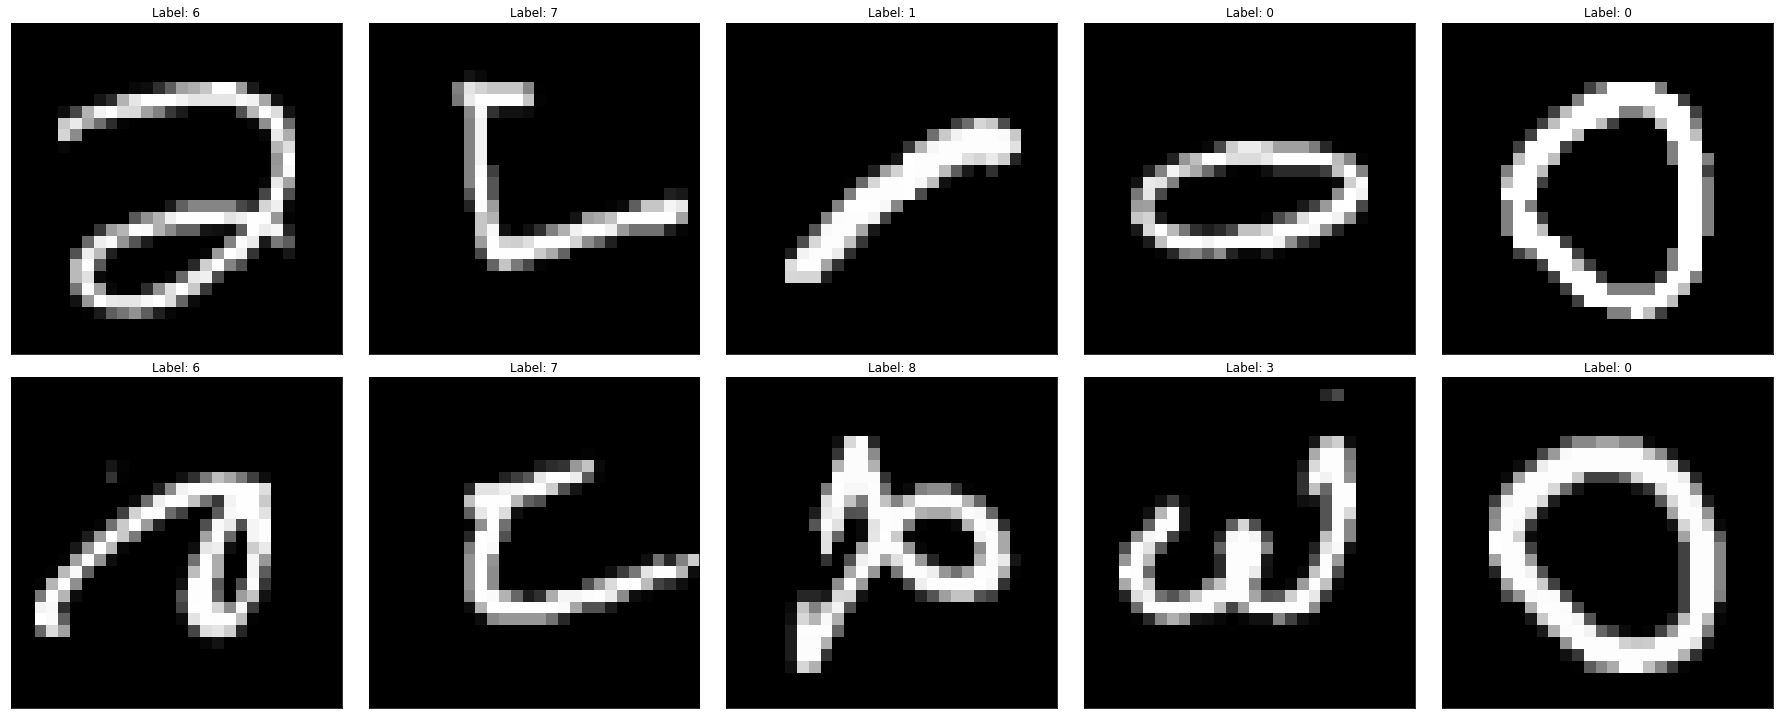

In [4]:
# Define function for plotting a sample of digits
def plot_sample(dataset, indices, title='10 randomly chosen digits'):
    # Initialize plot: show some digits at random
    fig, axs = plt.subplots(2, 5, figsize=(25, 10))
    # Add main title
    fig.suptitle(title)
    # Flatten axis
    axs = axs.flatten()
    # Loop through every randomly chosen index
    for i, k in enumerate(indices):
        # Get current image and label
        label, image, _ = dataset[k]
        # Make digit plot
        MNIST.plot_digit(label, image, ax=axs[i])
    # Tighten plot layout
    plt.tight_layout()
    # Show plot
    plt.show()

# Define 10 images at random
sample = np.random.choice(len(mnist), 10)
# Make sample plot
plot_sample(mnist, sample, title=None)

In [5]:
# Define random noise choice
random_noise = RandomNoise([
    # No noise
    Clip(),
    # Gaussian noise
    Compose([GaussianNoise(mu=0, sigma=0.4), Clip()]),
    # salt and pepper noise
    Compose([SaltPepperNoise(perc=0.4), Clip()]),
    # Occlusion noise
    Compose([OcclusionNoise(perc=0.4), Clip()])
])

# Define cast to tensor
to_tensor = ToTensor()

# Add random noise to mnist dataset
mnist.transform = random_noise

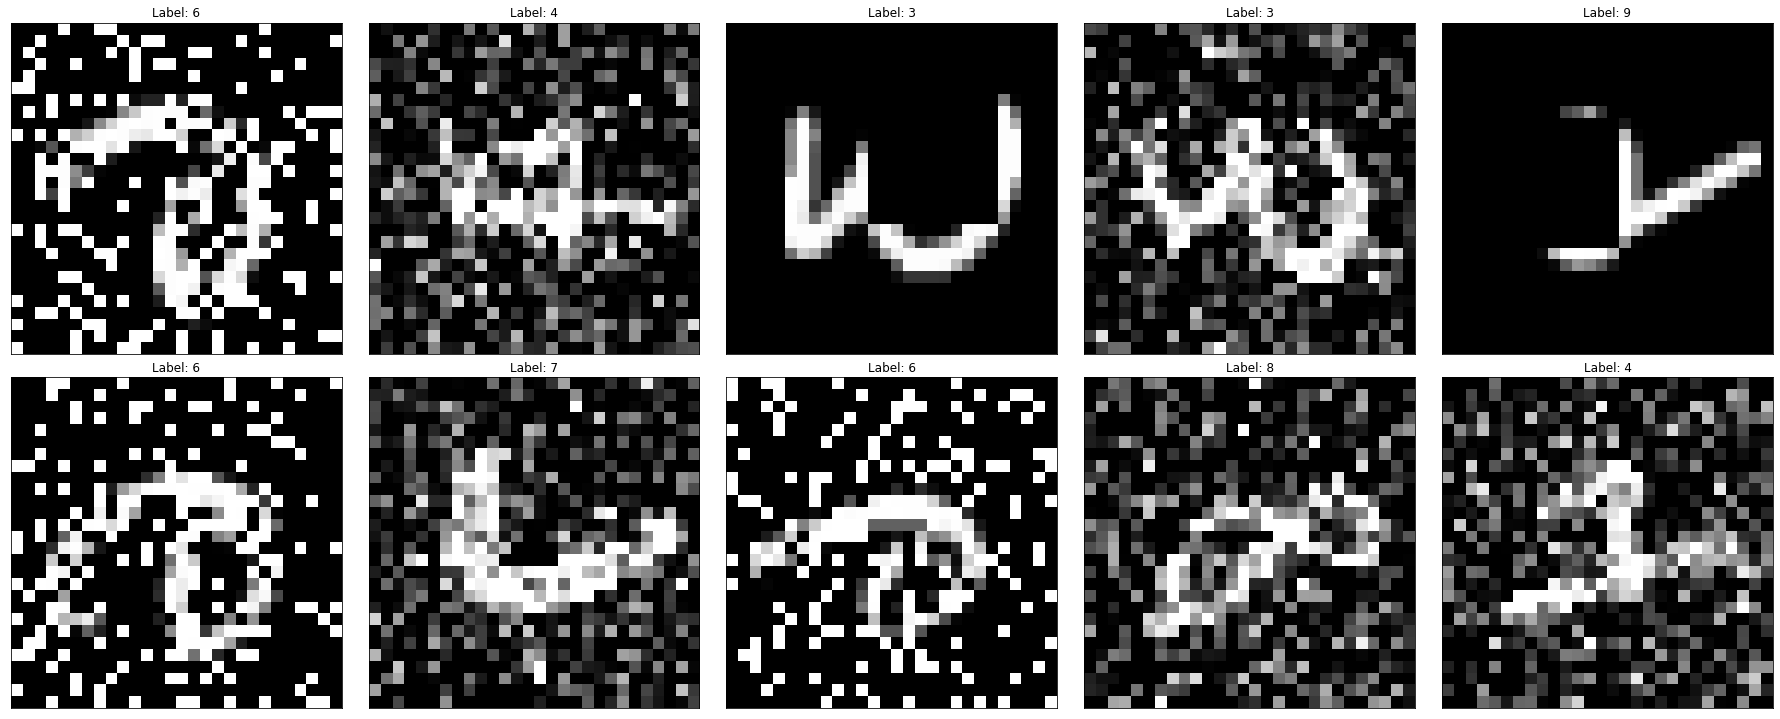

In [6]:
# Show some digits in training dataset
plot_sample(mnist, indices=np.random.choice(len(mnist), 10), title=None)

In [7]:
# Add to tensor transformation
mnist.transform = Compose([random_noise, to_tensor])

# Split MNIST dataset into train and test one
train_data, test_data = train_test_split(mnist, train_perc=0.8)

# Show new datasets length
print('Training dataset has length {:d}'.format(len(train_data)))
print('Test dataset has length {:d}'.format(len(test_data)))

Training dataset has length 48000
Test dataset has length 12000


### Model training

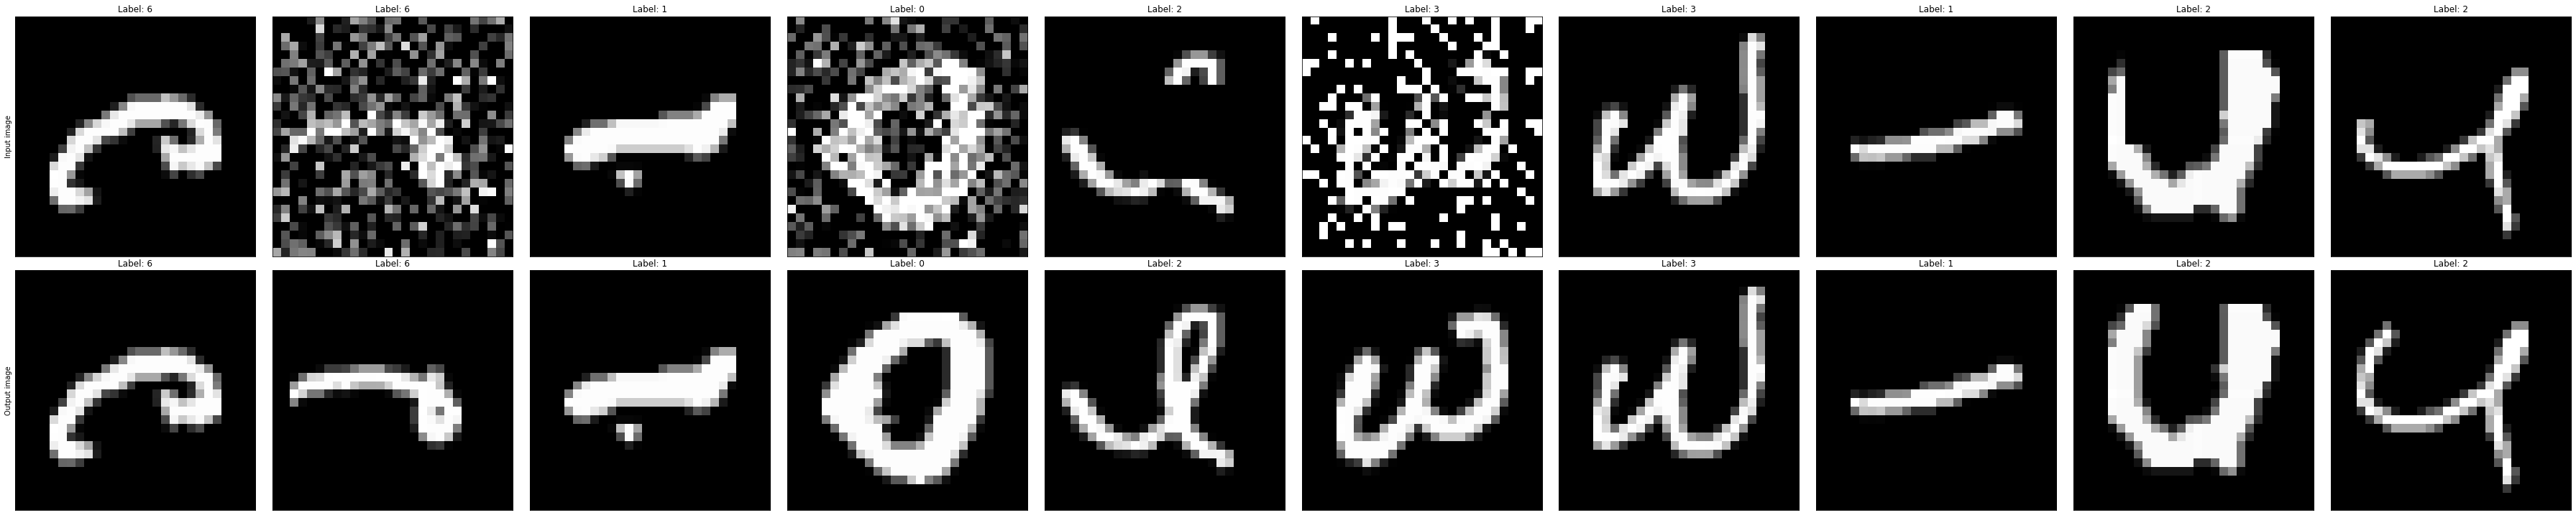

In [8]:
# Keep track of a fixed images batch

# Define number of images to sample
N = 10

# Retrieve a fixed test subset (no dynamic transformation)
test_sample = [test_data[i] for i in np.random.choice(len(test_data), N)]

# Initialize plot: show retrieved sample
fig, axs = plt.subplots(2, N, figsize=(50, 10), sharex='col', sharey='row')
# Set y label
axs[0, 0].set_ylabel('Input image')
axs[1, 0].set_ylabel('Output image')
# Loop through each sample
for i in range(N):
    # Get output label, input image and output image
    out_label, in_image, out_image = test_sample[i]
    
    # Plot input image
    MNIST.plot_digit(out_label.item(), in_image.squeeze(0).numpy(), ax=axs[0, i])
    
    # Plot output image
    MNIST.plot_digit(out_label.item(), out_image.squeeze(0).numpy(), ax=axs[1, i])
    
# Tighten plot layout
plt.tight_layout()
# Show plot
plt.show()

In [9]:
# Define new network
net = AutoEncoder(latent_dim=2)
# Move encoder to best device
net.to(device)

# Define optimizer
optim = torch.optim.Adam(net.parameters(), lr=1e-3, weight_decay=1e-5)
# Define loss function
loss_fn = torch.nn.MSELoss()

# Show network architecture
net

AutoEncoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTr

In [10]:
# Train the network

# Retrieve some 

# Define train and test dataloader
train_loader = DataLoader(train_data, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

# Get actual datatime
now = datetime.datetime.now()
# Define model path (set year-month-day hour:minute:second)
model_path = MODEL_PATH + '/%s_ae.pth' % now.strftime('%Y_%m_%d_%H_%M_%S')
# Define epochs path
epochs_path = MODEL_PATH + '/%s_ae.json' %  now.strftime('%Y_%m_%d_%H_%M_%S')

# # Define epochs iterator
# epochs_iter = tqdm.tqdm(desc='Training', iterable=train_test_epochs(
#     net=net, loss_fn=loss_fn, optim=optim,
#     num_epochs=1000, step_epochs=10,
#     train_data=train_loader, test_data=test_loader,
# ))
# 
# # Initialize results table
# results = {'train_loss': [], 'train_time': [], 'test_loss': [], 'test_time': []}
# # Loop through each training epoch
# for e, train_losses, train_times, test_losses, test_times in epochs_iter:
#     # Store either train and test times
#     results['train_loss'] += train_losses
#     results['train_time'] += train_times
#     results['test_loss'] += test_losses
#     results['test_time'] += test_times
#     
#     # Set network in evaluation mode
#     net.eval()
#     # Disable gradient computation
#     with torch.no_grad():
#         # Make test sample input images
#         in_images = torch.cat([test_sample[i][1] for i in range(len(test_sample))])
#         # Add channel dimension
#         in_images = in_images.unsqueeze(1)
#         # Move images to network device
#         in_images = in_images.to(net.device)
#         # # Debug
#         # print('Input images shape:', in_images.shape)
#         # Make reconstruction through the network
#         net_images = net(in_images)
#         
#         # Initialize plot: reconstructed images
#         fig, axs = plt.subplots(2, len(test_sample), figsize=(5*len(test_sample), 10), sharex='col', sharey='row')
#         # Add y axxis labels
#         axs[0, 0].set_ylabel('Original image')
#         axs[1, 0].set_ylabel('Reconstructed image')
#         # Loop through each sample
#         for i in range(len(test_sample)):
#             # Get output label, input image and output image
#             out_label, in_image, out_image = test_sample[i]
#             # Retrieve image out of predicted ones
#             net_image = net_images[i, :, :, :]
#             # Plot input image
#             MNIST.plot_digit(out_label.item(), in_image.squeeze(0).cpu().numpy(), ax=axs[0, i])
#             # Plot reconstructed image
#             MNIST.plot_digit(out_label.item(), net_image.squeeze(0).cpu().numpy(), ax=axs[1, i])
#         # Save plot
#         plt.savefig(MODEL_PATH + '/%s_epoch_%d_ae.png' % (now.strftime('%Y_%m_%d_%H_%M_%S'), e + 1))
#         # Close plot (not visualizing it)
#         plt.close()
#     
#     # Store network weights
#     with open(model_path, 'w') as file:
#         # Write model weights to file
#         torch.save(net.state_dict(), model_path)
#     
#     # Store epochs
#     with open(epochs_path, 'w') as file:
#         # Write epochs to file
#         json.dump(results, file)
#     
#     # Define current message
#     msg = 'Epoch number %d:\n' % (e + 1)
#     msg += 'Train loss (last): %.03f\n' % train_losses[-1]
#     msg += 'Train loss (mean): %.03f\n' % np.mean(train_losses)
#     msg += 'Test loss (last): %.03f\n' % test_losses[-1]
#     msg += 'Test loss (mean): %.03f\n' % np.mean(test_losses)
#     # Wirte out message
#     epochs_iter.write(msg)

In [11]:
# Load network from file

# Define autoencoder
net = AutoEncoder(latent_dim=2)
# Load weights from file
net.load_state_dict(torch.load('data/models/2020_09_03_11_27_07_ae.pth'))
# Move autoencoder to selected device
net.to(device)

AutoEncoder(
  (encoder_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU(inplace=True)
  )
  (encoder_lin): Sequential(
    (0): Linear(in_features=288, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder_lin): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (decoder_cnn): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTr

#### Digits

In [12]:
# Apply a transform for each digit

# Initialize expected images (one per digit)
in_images, out_images = [], []
# Retrieve available noise transformations
noise_transforms = random_noise.transforms
# Loop through each available digit
for i in range(10):
    # Go through each image in test dataset
    for out_label, _, out_image in test_data:
        
        # Cast output label to integer
        out_label = out_label.item()
        # Cast expected output image no numpy array
        out_image = out_image.squeeze(0).numpy()
        
        # Case current label does not match index
        if i != out_label:
            # Skip and go to next iteration
            continue
        
        # Initialize list of noised images
        noise_images = []
        # Loop through each available transformation
        for transform in noise_transforms:
            # Apply transformation, retrieve noise input image
            _, in_image, _ = transform(out_label, out_image.copy(), out_image.copy())
            # Store noised image
            noise_images.append(in_image)
        
        # Concatenate images together
        noise_images = np.stack(noise_images, axis=0)
        # Store noised images
        in_images.append(noise_images)
        # Store expected image
        out_images.append(out_image)
        
        # Exit inner loop, go to next digit
        break
        
# Concatenate output images
out_images = np.stack(out_images, axis=0)
# Concatenate input images
in_images = np.stack(in_images, axis=0)

# Check images shape
print('Expected output images have shape %s,' % str(out_images.shape), end=' ')
print('while input images have shape %s' % str(in_images.shape))

Expected output images have shape (10, 28, 28), while input images have shape (10, 4, 28, 28)


In [13]:
# Reconstruct images

# Initialize network reconstruction output
net_images = []
# Set network in evaluation mode
net.eval()
# Disable gradient computation
with torch.no_grad():
    # Loop through each transformation
    for i in range(len(noise_transforms)):
        # Retrieve noised input images
        net_input = torch.tensor(in_images[:, i, :, :]).to(net.device)
        # Reconstruct images
        net_output = net(net_input.unsqueeze(1)).squeeze(1).cpu()
        # Store current output as numpy array
        net_images.append(net_output.numpy())
    
# Concatenate network outputs to a single array
net_images = np.stack(net_images, axis=1)

# Check images shape
print('Network output images have shape %s' % str(net_images.shape))

Network output images have shape (10, 4, 28, 28)


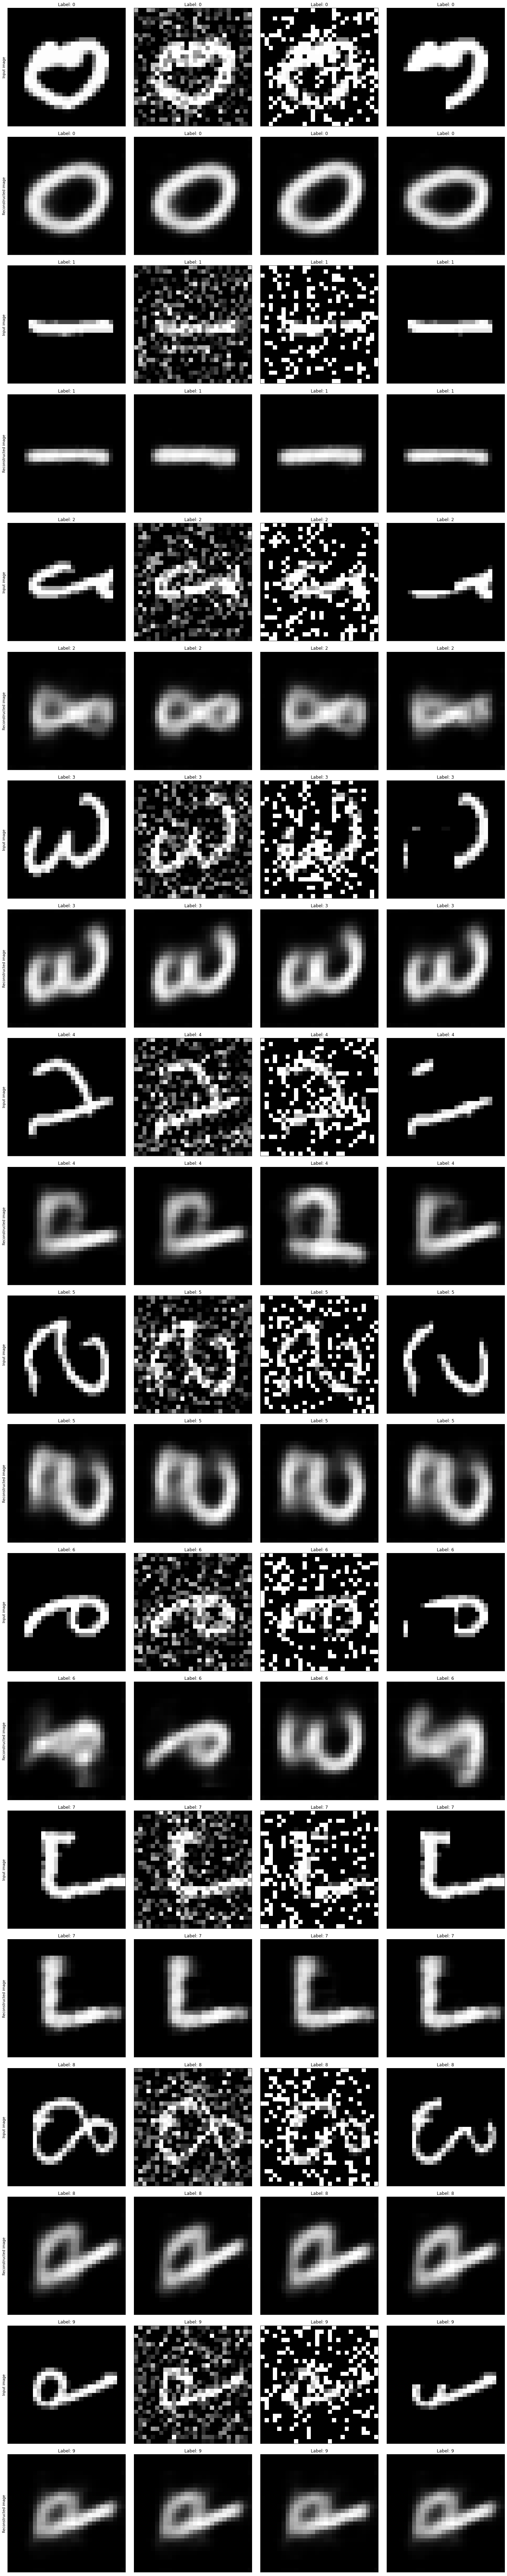

In [14]:
# Make reconstruction plot

# Initialize plot: show reconstruction for each digit and each type of noise
fig, axs = plt.subplots(10 * 2, 4, figsize=(4 * 5, 20 * 5))
# Loop through each couple of rows (first is input, second is output)
for i in range(0, 10):
    # First row: input images
    axs[i * 2 + 0, 0].set_ylabel('Input image')
    # Second row: reconstructed images
    axs[i * 2 + 1, 0].set_ylabel('Reconstructed image')
    
    # Loop through each input image
    for j in range(4):
        # Plot input digit
        MNIST.plot_digit(i, in_images[i, j, :, :], ax=axs[i * 2 + 0, j])
        # Plot reconstructed digit
        MNIST.plot_digit(i, net_images[i, j, :, :], ax=axs[i * 2 + 1, j])

# Tighten layout
plt.tight_layout()
# Show plot
plt.show()

#### Loss

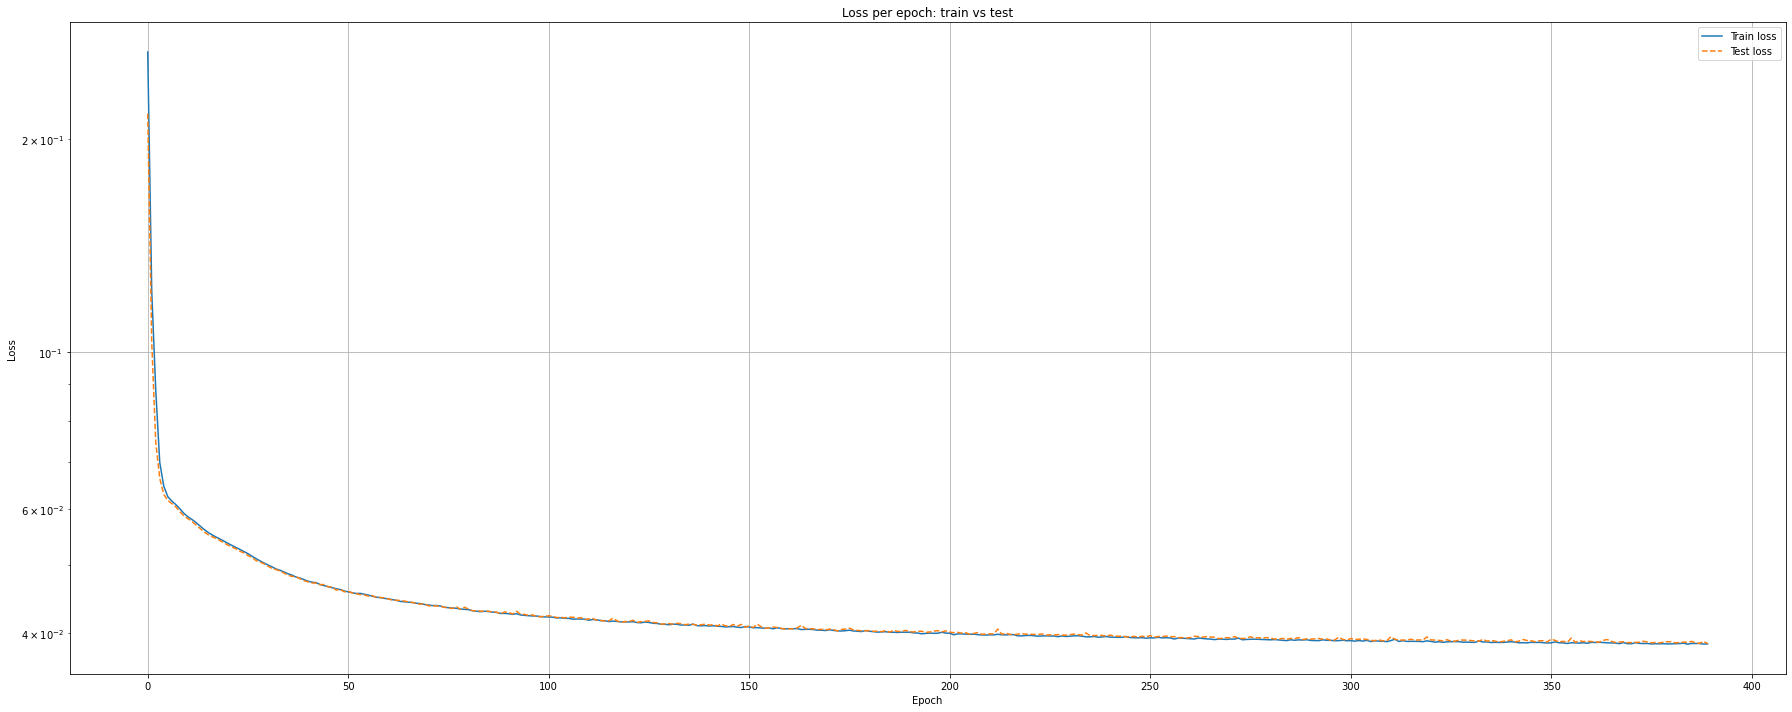

In [15]:
# Plot loss per epoch

# Load epochs as pandas dataframe
epochs = pd.read_json('data/models/2020_09_03_11_27_07_ae.json')

# Initialize plot: show either train and test losses
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
# Make train loss plot
ax.semilogy(epochs.train_loss, label='Train loss')
# Make test loss plot
ax.semilogy(epochs.test_loss, label='Test loss', ls='--')
# Define title and labels
ax.set_title('Loss per epoch: train vs test')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
# Add grid
ax.grid()
# Add legend
ax.legend()
# Tighten layout
plt.tight_layout()
# Make plot
plt.show()

### Latent space

In [16]:
# Retrieve test sample encodings

# Set network in evaluation mode
net.eval()
# Disable gradient computation
with torch.no_grad():
    
    # Initialize encoded images and labels lists
    enc_labels, enc_images = [], []
    
    # Loop trhough every batch in test dataset
    for out_labels, in_images, _ in test_loader:
        # Move input images to selected device
        in_images = in_images.to(device)
        # Encode images
        enc_images.append(net.encode(in_images).cpu())
        # Store labels
        enc_labels.append(out_labels.cpu())
        
# Concatenate all encoded images
enc_images = torch.cat(enc_images, dim=0).numpy()
# Concatenate all encoded labels
enc_labels = torch.cat(enc_labels, dim=0).numpy()

# Show either images and labels shape
print('Encoded images have shape (latent space dimension) %s' % str(enc_images.shape), end=' ')
print('while labels have shape %s' % str(enc_labels.shape))

Encoded images have shape (latent space dimension) (12000, 2) while labels have shape (12000, 1)


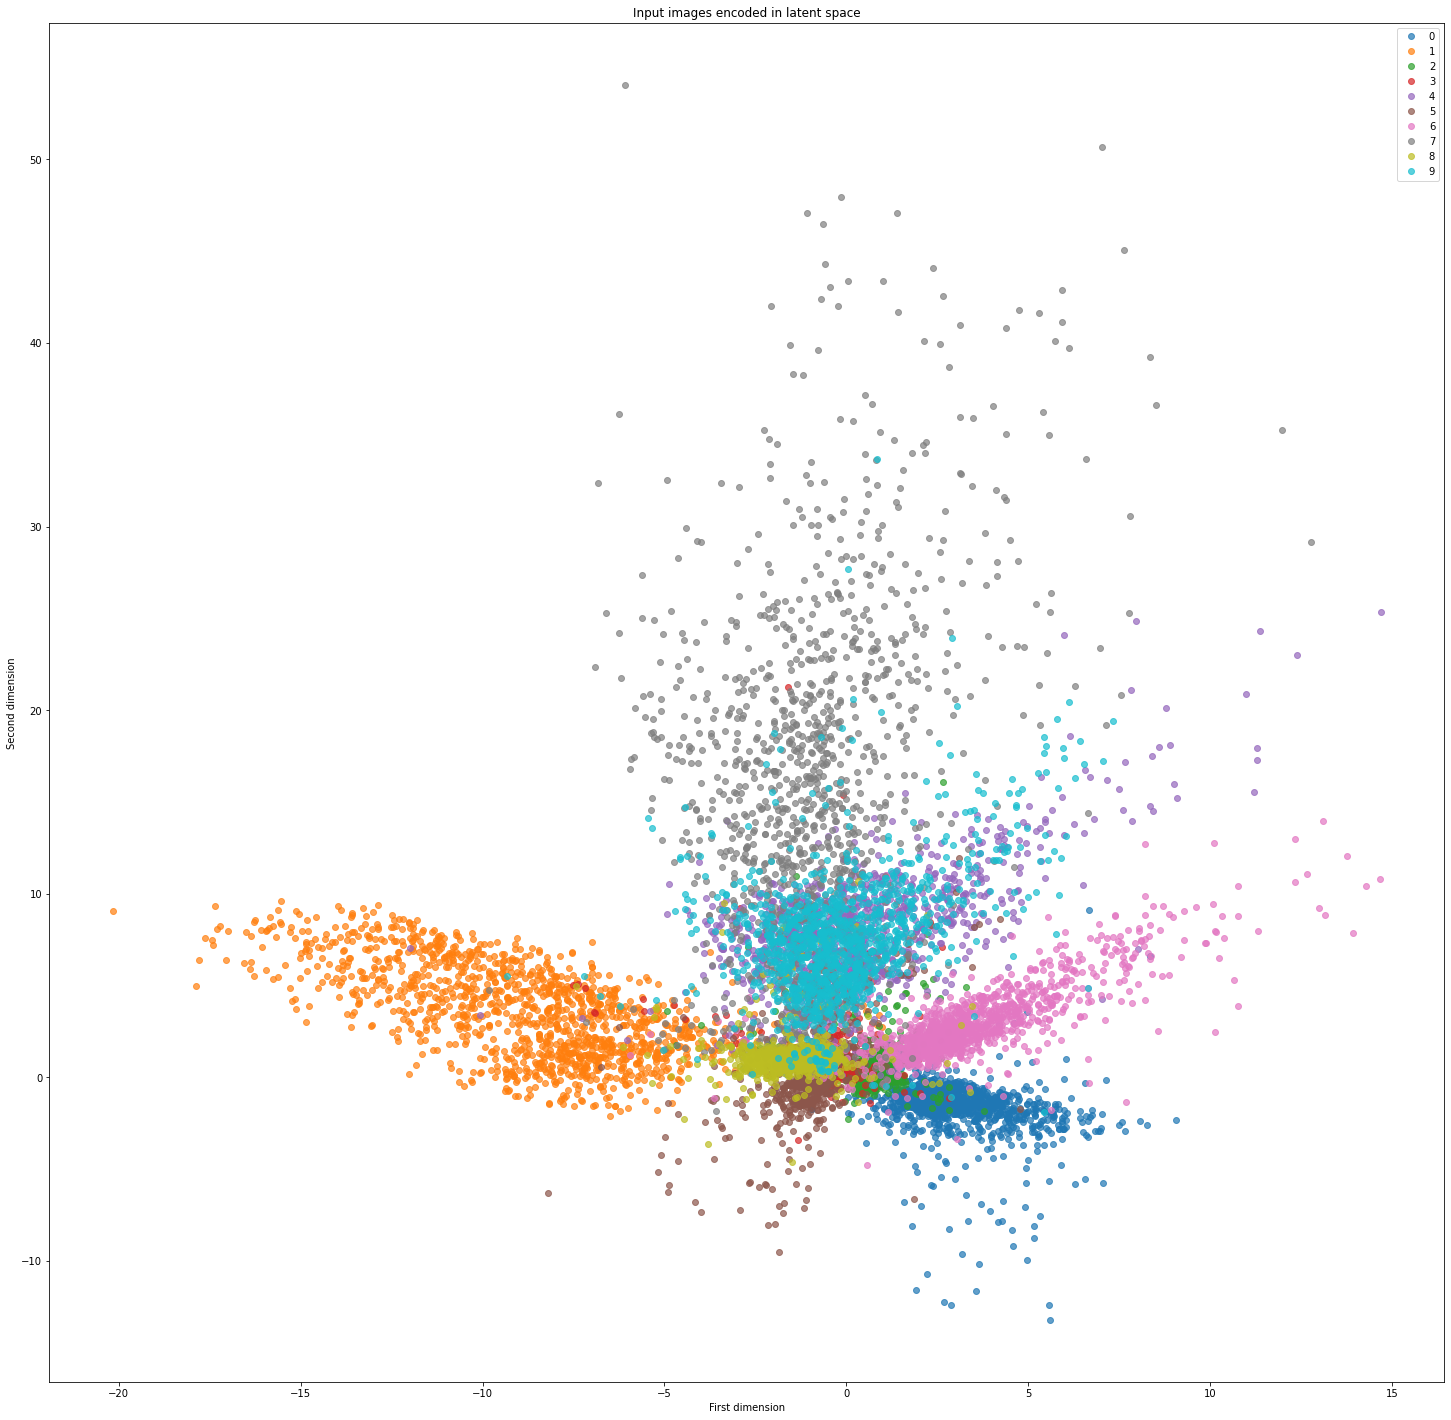

In [17]:
# Plot latent dimension

# Define digits
digits = sorted(set(enc_labels[:, 0]))

# Initialize plot: show 2 dimensional latent space
fig, ax = plt.subplots(figsize=(25, 25))
# Go through each digit
for i in digits:
    # Define x, y points
    xy = enc_images[enc_labels[:, 0] == i]
    # Make plot
    plt.plot(xy[:, 0], xy[:, 1], alpha=.7, linestyle='', marker='o')
# Set title and labels
ax.set_title('Input images encoded in latent space')
ax.set_ylabel('Second dimension')
ax.set_xlabel('First dimension')
# Show label
ax.legend(digits)
# Show plot
plt.show()